In [2]:
%matplotlib inline
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

# 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 120, 60, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)

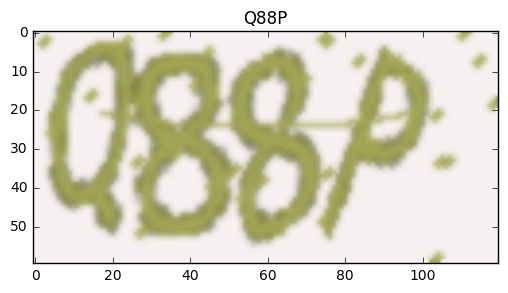

In [3]:
# test
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [4]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [5]:
def decode(y):
    acc = np.cumprod(np.max(y, axis=2)[0:])[-1]
    y = np.argmax(np.array(y), axis=2)[:,0]
    title = ''.join([characters[x] for x in y])
    return '%s %.6f' % (title, acc)

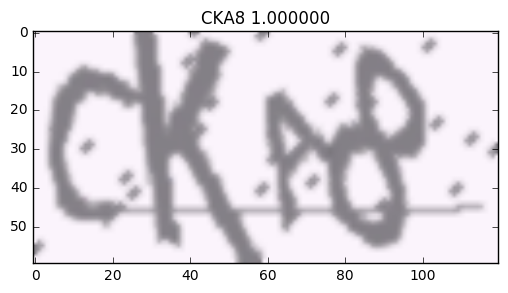

In [6]:
# test
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [7]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(3): # keras2
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
# 4个分类器多输出
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [304]:
from keras.utils import plot_model
from IPython.display import Image
# sudo pip install graphviz(安装接口)
# sudo apt-get install graphviz(安装软件本身)
# sudo pip install pydot
plot_model(model, to_file="model.png", show_shapes=True)
# Image('model.png')

In [8]:
model.fit_generator(gen(), steps_per_epoch=1000, epochs=10, workers=2, use_multiprocessing=True, 
                    validation_data=gen(), validation_steps=200) # keras2
# 多进程 workers=2, use_multiprocessing=True pickle_safe

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2057: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 11.0387 - c1_loss: 2.5382 - c2_loss: 2.6943 - c3_loss: 2.8540 - c4_loss: 2.9522 - c1_acc: 0.4198 - c2_acc: 0.3790 - c3_acc: 0.3370 - c4_acc: 0.3131

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2215: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 843s 843ms/step - loss: 11.0315 - c1_loss: 2.5366 - c2_loss: 2.6923 - c3_loss: 2.8523 - c4_loss: 2.9503 - c1_acc: 0.4200 - c2_acc: 0.3795 - c3_acc: 0.3373 - c4_acc: 0.3134 - val_loss: 3.4483 - val_c1_loss: 0.5954 - val_c2_loss: 0.7562 - val_c3_loss: 1.0094 - val_c4_loss: 1.0873 - val_c1_acc: 0.8075 - val_c2_acc: 0.7645 - val_c3_acc: 0.6922 - val_c4_acc: 0.6767
Epoch 2/10
1000/1000 [==============================] - 823s 823ms/step - loss: 2.7318 - c1_loss: 0.4364 - c2_loss: 0.6134 - c3_loss: 0.7994 - c4_loss: 0.8826 - c1_acc: 0.8570 - c2_acc: 0.8027 - c3_acc: 0.7551 - c4_acc: 0.7335 - val_loss: 1.6111 - val_c1_loss: 0.2149 - val_c2_loss: 0.3402 - val_c3_loss: 0.5087 - val_c4_loss: 0.5473 - val_c1_acc: 0.9278 - val_c2_acc: 0.8880 - val_c3_acc: 0.8486 - val_c4_acc: 0.8309
Epoch 3/10
1000/1000 [==============================] - 823s 823ms/step - loss: 1.5924 - c1_loss: 0.2252 - c2_loss: 0.3435 - c3_loss: 0.4843 - c4_loss: 0.5394 - c1_acc: 0.925

In [9]:
# save
model.save('captcha_model.h5')

In [7]:
from keras.models import load_model
model = load_model('captcha_model.h5')

Using TensorFlow backend.


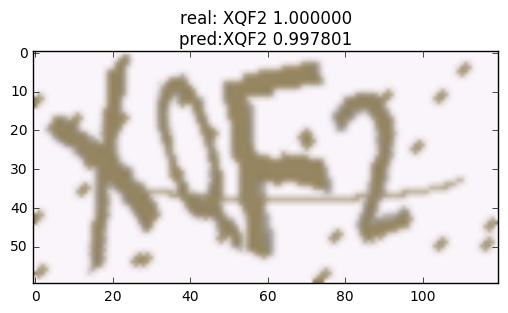

In [8]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [9]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred))) # python3
    return batch_acc / batch_num
evaluate(model)

100%|██████████| 20/20 [00:05<00:00,  3.39it/s]


0.8984375

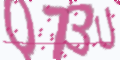

In [252]:
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
img

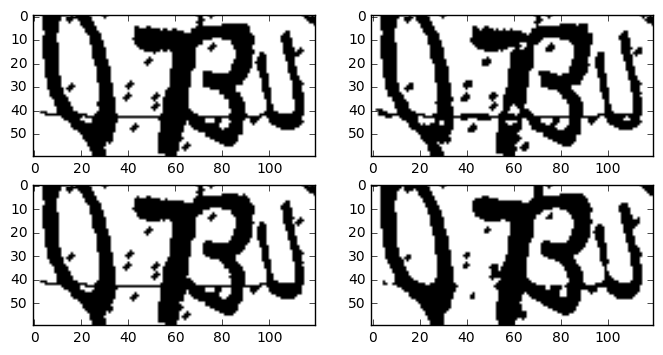

In [253]:
import cv2
# gray = im.convert('L') # 灰度图 
# blur = gray.convert('1') # 2 zhi hua

gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, 'gray')

# er zhi hua
_, blur1 = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
# 高斯 zi shi ying
blur2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# Otsu’s 二值化
_, blur3 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#（5,5）为高斯核的大小， 0 为标准差
blur4 = cv2.GaussianBlur(gray,(5,5),0)
# 阈值一定要设为 0！
_, blur4 = cv2.threshold(blur4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize = (8, 4))
plt.subplot(2, 2, 1)
plt.imshow(blur1, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(blur2, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(blur3, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(blur4, cmap='gray')

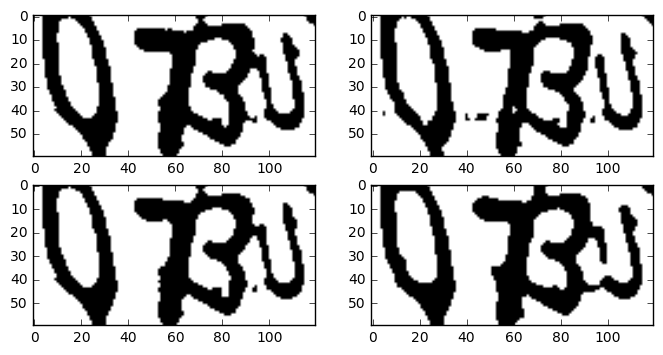

In [254]:
# zhong zhi lv bo
b1 = cv2.medianBlur(blur1, 5)
b2 = cv2.medianBlur(blur2, 5)
b3 = cv2.medianBlur(blur3, 5)
b4 = cv2.medianBlur(blur4, 5)
# gao si
"""b1 = cv2.GaussianBlur(blur1, (3,3),0)
b2 = cv2.GaussianBlur(blur2, (3,3),0)
b3 = cv2.GaussianBlur(blur3, (3,3),0)
b4 = cv2.GaussianBlur(blur4, (3,3),0)"""

plt.figure(figsize = (8, 4))
plt.subplot(2, 2, 1)
plt.imshow(b1, cmap='gray')
plt.subplot(2, 2, 2)
plt.imshow(b2, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(b3, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(b4, cmap='gray')

In [255]:
from keras import metrics
from keras.utils.np_utils import to_categorical
import keras.backend as K

In [314]:
X, y = next(gen(1))
original_array  = np.array(X)
target_idx      = np.argmax(model.predict(original_array), axis=2)[:,0]
target          = to_categorical(target_idx, n_class)
target_variable = K.variable(target)
loss            = metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
# 训练和测试两种模式下不完全一致
# 测试模式 no Dropout层，BN层等组件
# 需要在函数中传递一个learning_phase的标记 0训练/1测试
get_grad_values = K.function([model.input, K.learning_phase()], gradients)
grad_values     = get_grad_values([original_array, 0])[0]

In [315]:
grad_signs = np.sign(grad_values) # 取符号-1 +1 0
epsilon         = 4
perturbation    = grad_signs * epsilon
modified_array  = original_array + perturbation
deprocess_array = np.clip(modified_array, 0., 255.).astype(np.uint8) # 取值(0,255)

title_original = 'real: %s\npred:%s' % (decode(y), decode(model.predict(original_array)))
title_perturbation = 'noise:\n%s' % decode(model.predict(perturbation))
title_modified = 'adversarial:\n%s' % decode(model.predict(deprocess_array))

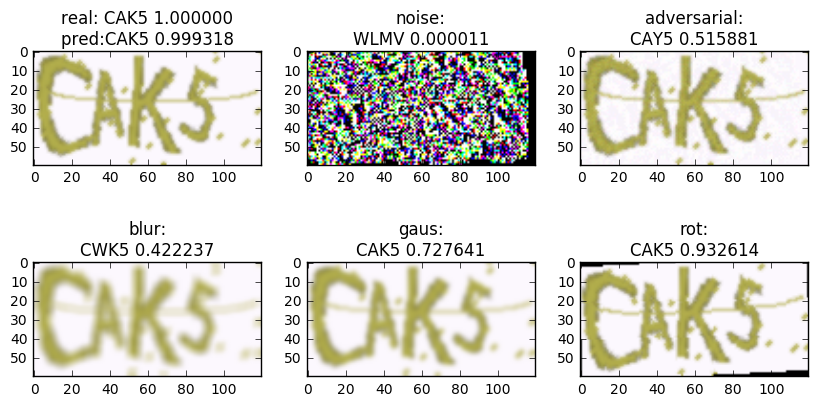

In [316]:
plt.figure(figsize = (10, 5))
plt.subplot(2, 3, 1)
plt.imshow(original_array[0], cmap='gray')
plt.title(title_original)

######
plt.subplot(2, 3, 2)
plt.imshow(perturbation[0], cmap='gray')
plt.title(title_perturbation)

######
plt.subplot(2, 3, 3)
plt.imshow(deprocess_array[0], cmap='gray')
plt.title(title_modified)

##### lv bo
img_blur = cv2.blur(original_array[0], (5,5))
title_blur = 'blur:\n%s' % decode(model.predict(np.expand_dims(img_blur, 0)))
plt.subplot(2, 3, 4)
plt.imshow(img_blur, cmap='gray')
plt.title(title_blur)

##### gao si
img_gaus = cv2.GaussianBlur(original_array[0], (5,5), 0)
title_gaus = 'gaus:\n%s' % decode(model.predict(np.expand_dims(img_gaus, 0)))
plt.subplot(2, 3, 5)
plt.imshow(img_gaus, cmap='gray')
plt.title(title_gaus)

##### xuan zhuan
img_rot = Image.fromarray(original_array[0]).rotate(3)
title_rot = 'rot:\n%s' % decode(model.predict(np.expand_dims(img_rot, 0)))
plt.subplot(2, 3, 6)
plt.imshow(img_rot, cmap='gray')
plt.title(title_rot)

In [235]:
# here need to design a test from folder
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred))) # python3
    return batch_acc / batch_num
evaluate(model)

100%|██████████| 20/20 [00:05<00:00,  3.36it/s]


0.8828125

In [230]:
import os
from PIL import Image
test_path = 'test/'
flist = os.listdir(test_path)
flen = len(flist)
X = np.zeros((flen, height, width, 3), dtype=np.uint8)
y = [np.zeros((flen, n_class), dtype=np.uint8) for i in range(n_len)]
for i in range(flen):
    X[i] = Image.open(test_path + flist[i])
    for j, ch in enumerate(flist[i][0:4]):
        y[j][i, :] = 0
        y[j][i, characters.find(ch)] = 1

In [238]:
acc = 0
for i in tqdm(range(flen)):
    y_pred = model.predict(X[i:i+1])
    y_pred = np.argmax(y_pred, axis=2).T
    y_true = np.argmax(y, axis=2).T
    acc += np.mean(list(map(np.array_equal, y_true[i], y_pred[0]))) # python3
acc / flen

100%|██████████| 1000/1000 [00:10<00:00, 92.12it/s]


0.96425000000000005

[ 3 14 20 24]
[ 3 14 20 24]


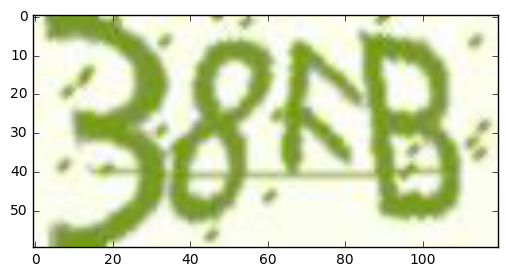

In [231]:
y_pred = model.predict(X[1:2])
y_pred = np.argmax(y_pred, axis=2).T
y_true = np.argmax(y, axis=2).T
print(y_true[1])
print(y_pred[0])
plt.imshow(X[0], 'gray') # 3 14 20 24